In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('SolarPrediction.csv')
data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


In [4]:
data.isnull().sum()

UNIXTime                  0
Data                      0
Time                      0
Radiation                 0
Temperature               0
Pressure                  0
Humidity                  0
WindDirection(Degrees)    0
Speed                     0
TimeSunRise               0
TimeSunSet                0
dtype: int64

In [5]:
from scipy import stats
import re

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score
import xgboost as xgb

from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential

In [6]:
df = data.copy()
df['Data'] = df['Data'].apply(lambda x: x.split()[0])
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [7]:
df['Month'] = pd.to_datetime(df['Data']).dt.month
df['Day'] = pd.to_datetime(df['Data']).dt.day

df['Hour'] = pd.to_datetime(df['Time']).dt.hour
df['Minute'] = pd.to_datetime(df['Time']).dt.minute
df['Second'] = pd.to_datetime(df['Time']).dt.second

df.drop(['Data', 'Time'], axis=1, inplace=True)
df.head()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second
0,1475229326,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26
1,1475229023,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23
2,1475228726,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26
3,1475228421,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21
4,1475228124,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24


In [8]:
df['risehour'] = df['TimeSunRise'].apply(lambda x : re.search(r'^\d+', x).group(0)).astype(int)
df['riseminute'] = df['TimeSunRise'].apply(lambda x : re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

df['sethour'] = df['TimeSunSet'].apply(lambda x : re.search(r'^\d+', x).group(0)).astype(int)
df['setminute'] = df['TimeSunSet'].apply(lambda x : re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

In [9]:
df.drop(['UNIXTime','TimeSunRise','TimeSunSet'], axis=1, inplace=True)
df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
0,1.21,48,30.46,59,177.39,5.62,9,29,23,55,26,6,13,18,13
1,1.21,48,30.46,58,176.78,3.37,9,29,23,50,23,6,13,18,13
2,1.23,48,30.46,57,158.75,3.37,9,29,23,45,26,6,13,18,13
3,1.21,48,30.46,60,137.71,3.37,9,29,23,40,21,6,13,18,13
4,1.17,48,30.46,62,104.95,5.62,9,29,23,35,24,6,13,18,13


In [10]:
df.shape

(32686, 15)

In [11]:
input_features = df.drop('Radiation', axis=1)
target = df['Radiation']

Feature Selection

In [12]:
corr_matrix = df.corr()
corr_matrix

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
Radiation,1.000000,0.734955,0.119016,-0.226171,-0.230324,0.073627,-0.095450,0.039978,0.004398,-0.000730,-0.031270,NaN,-0.092850,0.048719,-0.039816
Temperature,0.734955,1.000000,0.311173,-0.285055,-0.259421,-0.031458,-0.354560,-0.123705,0.197464,-0.001934,-0.036147,NaN,-0.380968,0.300920,-0.242881
Pressure,0.119016,0.311173,1.000000,-0.223973,-0.229010,-0.083639,-0.341759,-0.024633,0.091069,0.001860,-0.031102,NaN,-0.380399,0.151939,-0.119599
Humidity,-0.226171,-0.285055,-0.223973,1.000000,-0.001833,-0.211624,-0.068854,0.014637,0.077899,0.000499,-0.027682,NaN,-0.023955,0.145143,-0.119526
WindDirection(Degrees),-0.230324,-0.259421,-0.229010,-0.001833,1.000000,0.073092,0.181485,-0.082354,-0.077969,-0.000602,-0.032568,NaN,0.176929,-0.078540,0.070030
Speed,0.073627,-0.031458,-0.083639,-0.211624,0.073092,1.000000,0.150822,0.117337,-0.057939,0.000192,-0.032934,NaN,0.167075,-0.159384,0.119926
Month,-0.095450,-0.354560,-0.341759,-0.068854,0.181485,0.150822,1.000000,0.038027,-0.005396,0.000168,0.220563,NaN,0.952472,-0.784783,0.541883
Day,0.039978,-0.123705,-0.024633,0.014637,-0.082354,0.117337,0.038027,1.000000,-0.008010,-0.000196,0.089078,NaN,0.274522,-0.263575,0.265662
Hour,0.004398,0.197464,0.091069,0.077899,-0.077969,-0.057939,-0.005396,-0.008010,1.000000,-0.004052,0.004199,NaN,-0.006772,0.008629,-0.007056
Minute,-0.000730,-0.001934,0.001860,0.000499,-0.000602,0.000192,0.000168,-0.000196,-0.004052,1.000000,0.002517,NaN,-0.000158,0.001052,-0.002215


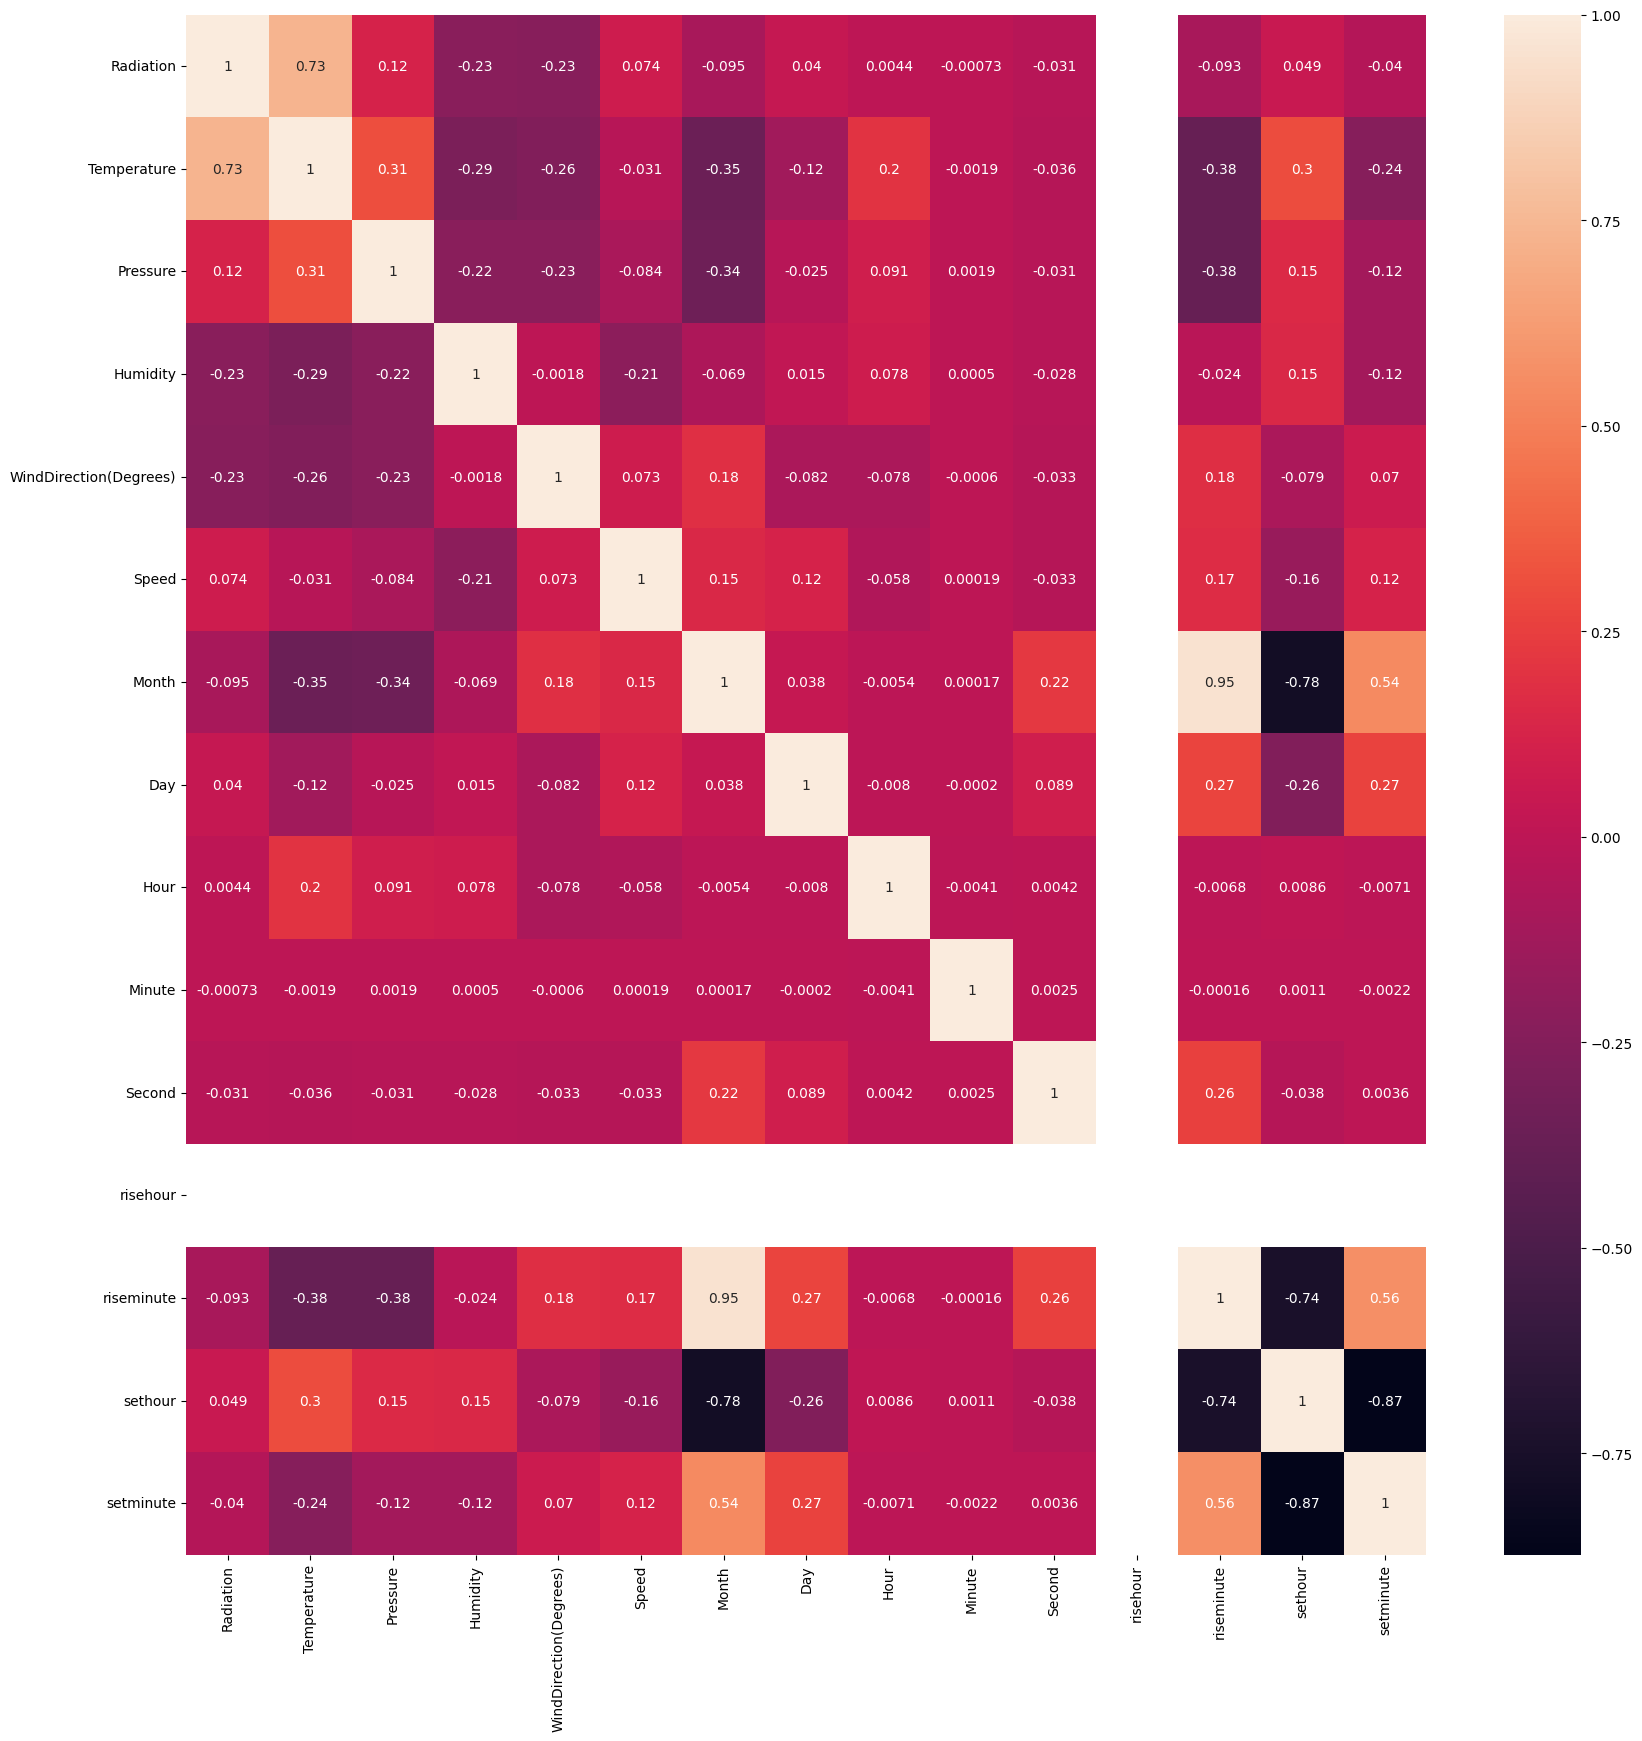

In [13]:
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [14]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_Y = label_encoder.fit_transform(target)
train_Y[:5]
# this was important as target was continous and we need to convert it into categorical

array([ 9,  9, 11,  9,  5], dtype=int64)

In [15]:
target_cont = df['Radiation'].apply(lambda x: int(x*100))
target_cont[:5]

0    121
1    121
2    123
3    121
4    117
Name: Radiation, dtype: int64

In [16]:
scaled_input_features = MinMaxScaler().fit_transform(input_features)
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(scaled_input_features,target_cont)

In [17]:
scores = pd.DataFrame(fit.scores_)
columns = pd.DataFrame(input_features.columns)
featureScores = pd.concat([columns,scores],axis=1)
featureScores.columns = ['Features','feature_imp'] 
featureScores.sort_values(by=['feature_imp'], ascending=False, inplace=True)
featureScores

,Features,feature_imp
12,sethour,12207.531454
5,Month,4684.579610
11,riseminute,4015.062771
3,WindDirection(Degrees),3271.827277
6,Day,2841.926850
8,Minute,2702.449333
9,Second,2288.673032
13,setminute,1863.712087
0,Temperature,1651.685632
2,Humidity,1588.087433


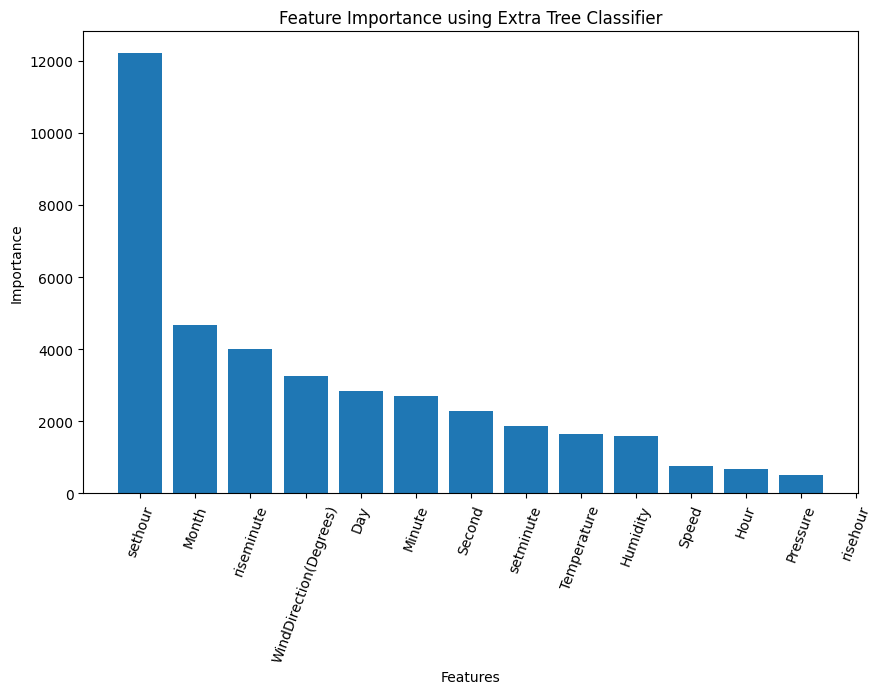

In [18]:
plt.figure(figsize = (10, 6))
plt.bar(featureScores.Features, featureScores.feature_imp)
plt.xticks(rotation = 70)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance using Extra Tree Classifier")
plt.show()

In [19]:
model = ExtraTreesClassifier(n_estimators=2, verbose=2)
model.fit(scaled_input_features, target_cont)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 2


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.0s remaining:    0.0s


building tree 2 of 2


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   40.0s finished


ExtraTreesClassifier(n_estimators=2, verbose=2)

In [20]:
feature_importances = pd.DataFrame(model.feature_importances_, index = input_features.columns, columns = ["feature_imp"])
feature_importances.sort_values(by = 'feature_imp', ascending=False, inplace = True)
feature_importances

,feature_imp
WindDirection(Degrees),0.160576
Minute,0.153273
Speed,0.123908
Second,0.122247
Humidity,0.110488
Hour,0.090696
Temperature,0.083246
Pressure,0.076895
Day,0.033371
setminute,0.022111


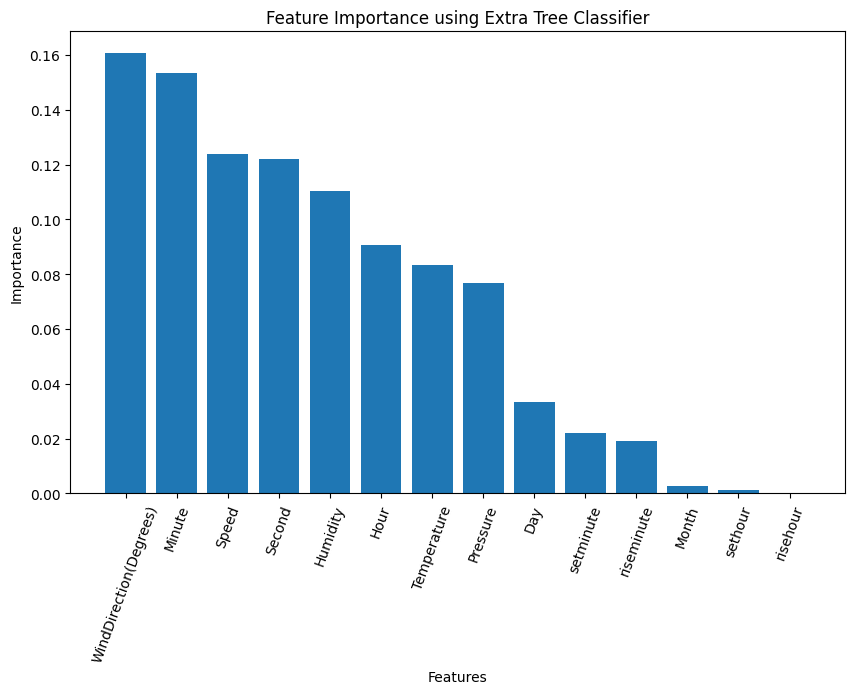

In [21]:
plt.figure(figsize = (10, 6))
plt.bar(feature_importances.index, feature_importances["feature_imp"])
plt.xticks(rotation = 70)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance using Extra Tree Classifier")
plt.show()

Feature Engineering with BoxCox, Log, Min-Max and Standard transformation

C:\Users\ANURAG\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\ANURAG\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


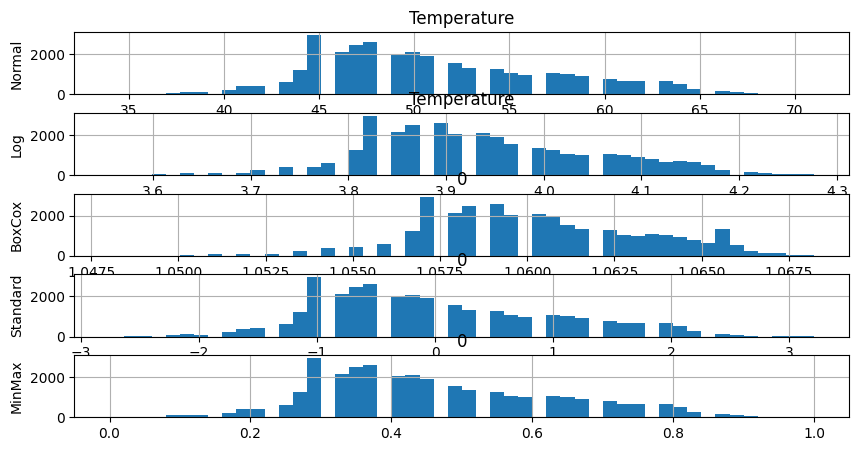

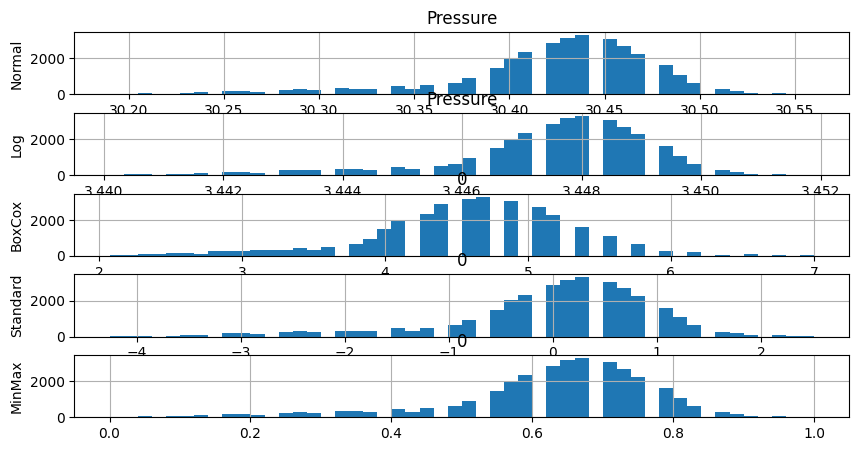

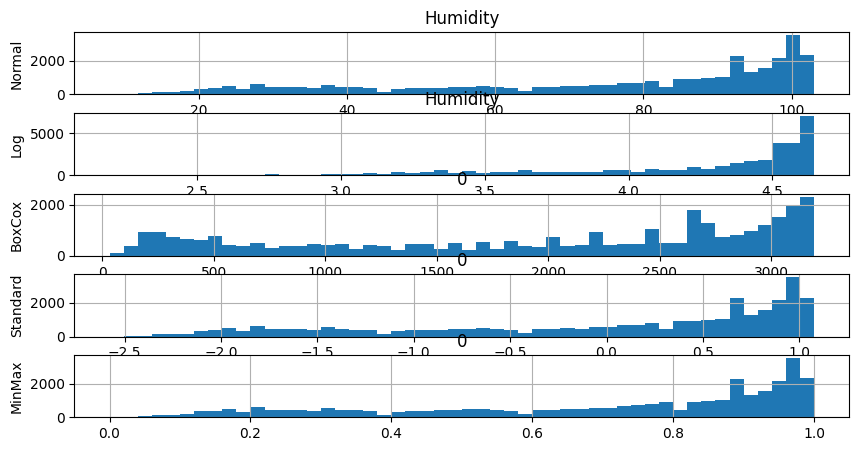

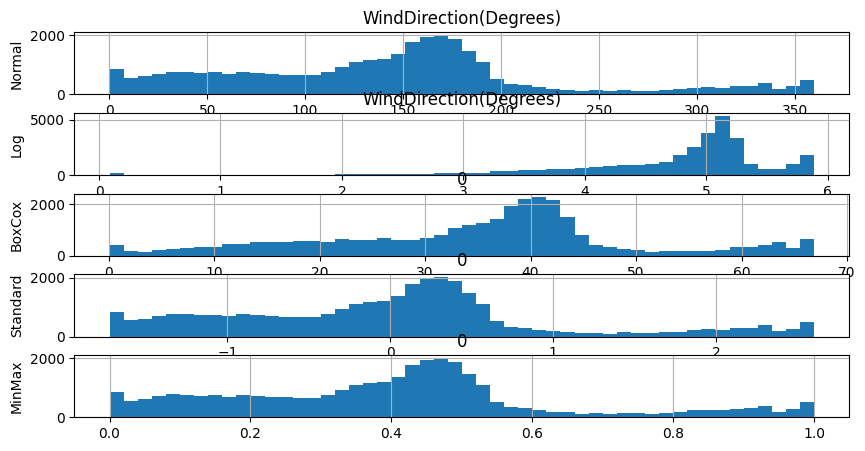

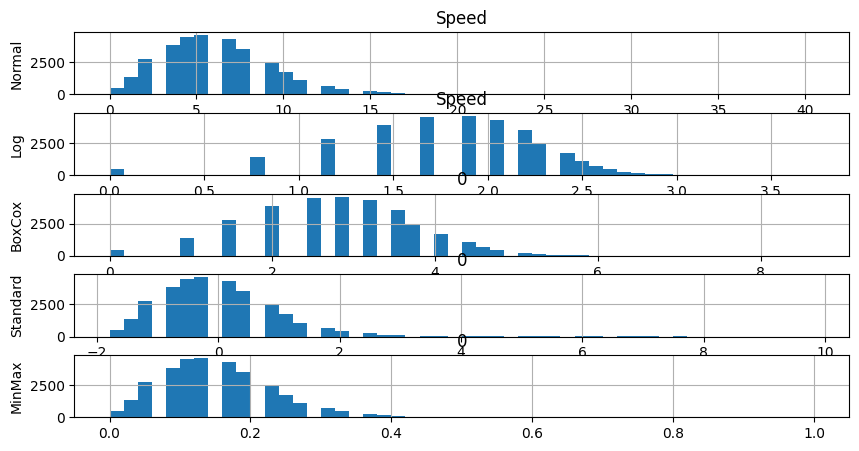

In [27]:
features_to_transform = ['Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed']
for feature in features_to_transform:
    fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5, 1, figsize=(10,5))
    pd.DataFrame(input_features[feature]).hist(ax=ax1, bins=50)
    pd.DataFrame((input_features[feature]+1).transform(np.log)).hist(ax=ax2, bins=50)
    pd.DataFrame(stats.boxcox(input_features[feature]+1)[0]).hist(ax=ax3, bins=50)
    pd.DataFrame(StandardScaler().fit_transform(np.array(input_features[feature]).reshape(-1,1))).hist(ax=ax4, bins=50)
    pd.DataFrame(MinMaxScaler().fit_transform(np.array(input_features[feature]).reshape(-1,1))).hist(ax=ax5, bins=50)
    
    ax1.set_ylabel('Normal')
    ax2.set_ylabel('Log')
    ax3.set_ylabel('BoxCox')
    ax4.set_ylabel('Standard')
    ax5.set_ylabel('MinMax')

In [28]:
input_features.head()

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
0,48,30.46,59,177.39,5.62,9,29,23,55,26,6,13,18,13
1,48,30.46,58,176.78,3.37,9,29,23,50,23,6,13,18,13
2,48,30.46,57,158.75,3.37,9,29,23,45,26,6,13,18,13
3,48,30.46,60,137.71,3.37,9,29,23,40,21,6,13,18,13
4,48,30.46,62,104.95,5.62,9,29,23,35,24,6,13,18,13


In [29]:
transform = {'Temperature' : (input_features['Temperature']+1).transform(np.log), 
             'Pressure': stats.boxcox(input_features['Pressure']+1)[0], 
            'Humidity' : stats.boxcox(input_features['Humidity']+1)[0], 
            'Speed' : (input_features['Speed']+1).transform(np.log), 
            'WindDirection(Degrees)' : MinMaxScaler().fit_transform(
                np.array(input_features['WindDirection(Degrees)']).reshape(-1, 1))}

for i in transform:
    input_features[i] = transform[i]
input_features.head()

C:\Users\ANURAG\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\ANURAG\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
0,3.89182,5.044903e+152,1139.358665,0.492692,1.890095,9,29,23,55,26,6,13,18,13
1,3.89182,5.044903e+152,1104.046980,0.490996,1.474763,9,29,23,50,23,6,13,18,13
2,3.89182,5.044903e+152,1069.253545,0.440894,1.474763,9,29,23,45,26,6,13,18,13
3,3.89182,5.044903e+152,1175.187489,0.382426,1.474763,9,29,23,40,21,6,13,18,13
4,3.89182,5.044903e+152,1248.392213,0.291391,1.890095,9,29,23,35,24,6,13,18,13


Standardisation and Splitting

In [30]:
xtrain,xtest,ytrain,ytest = train_test_split(input_features, target, test_size=0.2, random_state=1)
scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)

(26148, 14) (6538, 14) (26148,) (6538,)


# XGBoost model

In [31]:
from xgboost import XGBRegressor
params = {
    'learning_rate': 0.1,
    'max_depth': 8,
}
model = XGBRegressor(**params)
model.fit(xtrain, ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [32]:
y_pred = model.predict(xtest)
rmse = np.sqrt(mean_squared_error(ytest, y_pred))
print('Testing Performance\nRMSE: ', rmse)
r2 = r2_score(ytest, y_pred)
print('R2: ', r2)

Testing Performance
RMSE:  81.44599312822656
R2:  0.9319009527409744


# Using MultiLayer Perceptron for prediction

In [33]:
input_features.shape

(32686, 14)

In [34]:
model = None # Clearing the NN.( If you are running this for the first time. )
model = Sequential()

model.add(Dense(128, input_dim=14, activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(1, activation='relu'))

model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics='mse')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1920      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 3

In [35]:
history = model.fit(xtrain, ytrain, validation_split=0.1, epochs=50, batch_size=32)

C:\Users\ANURAG\AppData\Roaming\Python\Python310\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Epoch 1/50
736/736 [==============================] - 2s 2ms/step - loss: 55198.0781 - mse: 55198.0781 - val_loss: 27779.5273 - val_mse: 27779.5273
Epoch 2/50
736/736 [==============================] - 1s 2ms/step - loss: 32358.1504 - mse: 32358.1504 - val_loss: 25076.9238 - val_mse: 25076.9238
Epoch 3/50
736/736 [==============================] - 1s 2ms/step - loss: 29822.6133 - mse: 29822.6133 - val_loss: 21123.9785 - val_mse: 21123.9785
Epoch 4/50
736/736 [==============================] - 1s 2ms/step - loss: 27222.6348 - mse: 27222.6348 - val_loss: 18370.2383 - val_mse: 18370.2383
Epoch 5/50
736/736 [==============================] - 1s 2ms/step - loss: 25608.1172 - mse: 25608.1172 - val_loss: 17333.3770 - val_mse: 17333.3770
Epoch 6/50
736/736 [==============================] - 1s 2ms/step - loss: 24308.0957 - mse: 24308.0957 - val_loss: 15882.5820 - val_mse: 15882.5820
Epoch 7/50
736/736 [==============================] - 1s 2ms/step - loss: 23325.9609 - mse: 23325.9609 - val_los

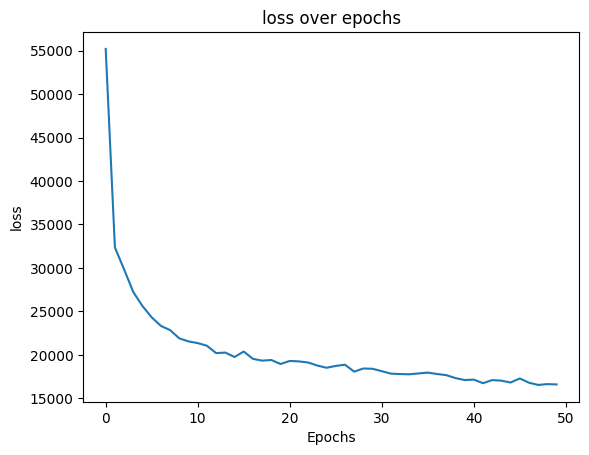

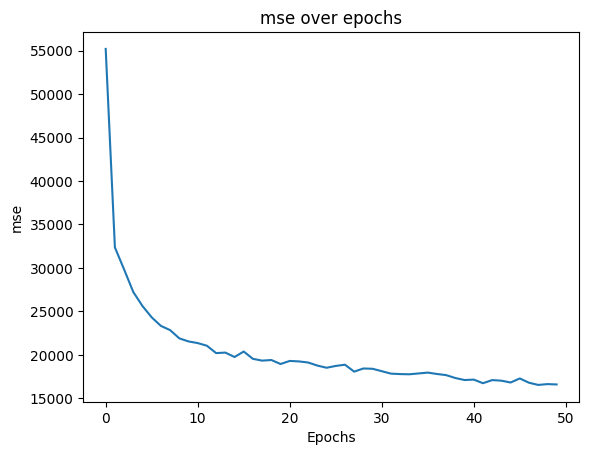

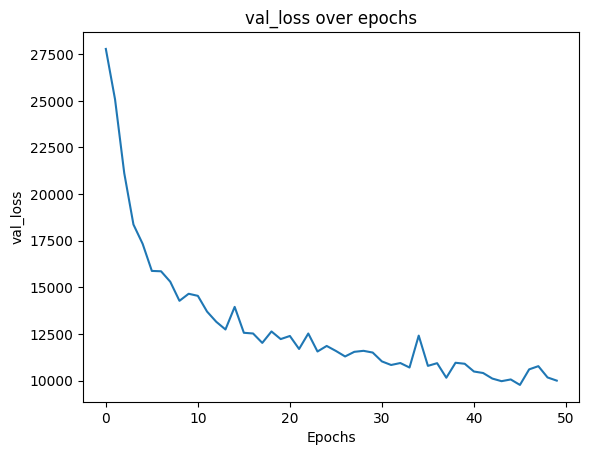

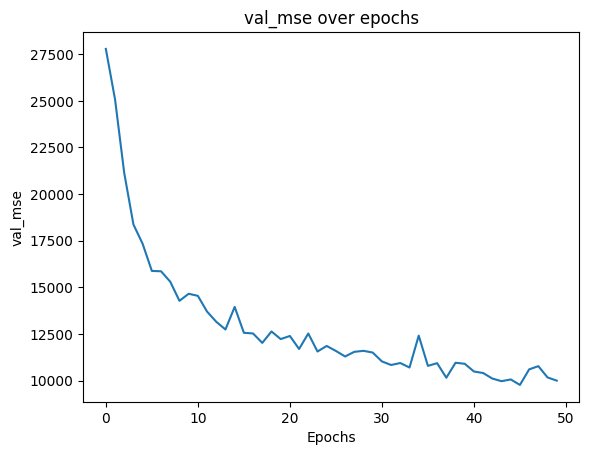

In [36]:
fit = history.history
for i in fit:
    plt.plot(fit[i])
    plt.title(i+" over epochs")
    plt.ylabel(i)
    plt.xlabel("Epochs")
    plt.show()

In [38]:
from sklearn.metrics import mean_absolute_error
y_pred = model.predict(xtest)
mean_absolute_error(ytest, y_pred)

205/205 [==============================] - 0s 1ms/step


46.5313243308203